# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt


In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_finance data paths
    lst_df_tech_paths = ast.literal_eval(config.get("paths_df_tech_processed"))
    

In [4]:
# Import data 
path = lst_df_tech_paths[0]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_CMG,adClose_ELC,adClose_FPT,adClose_ITD,adClose_PSD,adClose_SAM,adClose_SGT,adClose_SRA,adClose_ST8,adClose_TYA
date,,,,,,,,,,
2018-12-10,14.860,6.472,19.072,6.673,7.794,5.959,3.774,10.390,10.057,6.507
2018-12-11,15.339,6.316,19.007,6.733,7.794,5.816,3.774,10.715,10.057,6.507
2018-12-12,14.620,6.316,19.180,6.643,7.014,5.825,3.774,11.345,10.057,6.507
2018-12-13,14.890,6.472,19.244,6.703,6.372,5.783,3.774,10.855,10.736,6.507
2018-12-14,14.860,6.472,19.050,6.643,6.419,5.732,3.753,11.927,10.736,6.539
...,...,...,...,...,...,...,...,...,...,...
2019-09-18,24.784,5.243,27.843,7.750,7.858,6.856,4.125,5.884,10.631,9.501
2019-09-19,24.784,5.161,28.534,7.750,7.858,6.796,3.870,5.760,10.631,9.501
2019-09-20,24.202,5.161,28.731,7.684,7.858,6.839,3.870,5.698,10.631,9.894


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_CMG,adClose_ELC,adClose_FPT,adClose_ITD,adClose_PSD,adClose_SAM,adClose_SGT,adClose_SRA,adClose_ST8,adClose_TYA
date,,,,,,,,,,
2018-12-11,3.223419,-2.410383,-0.340814,0.899146,0.000000,-2.399731,0.000000,3.128008,0.000000,0.000000
2018-12-12,-1.615074,-2.410383,0.566275,-0.449573,-10.007698,-2.248699,0.000000,9.191530,0.000000,0.000000
2018-12-13,0.201884,0.000000,0.901846,0.449573,-18.244804,-2.953516,0.000000,4.475457,6.751516,0.000000
2018-12-14,0.000000,0.000000,-0.115352,-0.449573,-17.641776,-3.809364,-0.556439,14.793070,6.751516,0.491778
2018-12-15,0.000000,0.000000,-0.115352,-0.449573,-17.641776,-3.809364,-0.556439,14.793070,6.751516,0.491778
...,...,...,...,...,...,...,...,...,...,...
2019-09-18,66.783311,-18.989493,45.988884,16.139667,0.821144,15.052861,9.300477,-43.368624,5.707467,46.011987
2019-09-19,66.783311,-20.256489,49.611997,16.139667,0.821144,14.045981,2.543720,-44.562079,5.707467,46.011987
2019-09-20,62.866756,-20.256489,50.644924,15.150607,0.821144,14.767578,2.543720,-45.158807,5.707467,52.051637


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_ELC và adClose_PSD: 171.4
Khoảng cách Euclide của adClose_FPT và adClose_ITD: 201.4
Khoảng cách Euclide của adClose_FPT và adClose_SAM: 198.6
Khoảng cách Euclide của adClose_FPT và adClose_TYA: 241.4
Khoảng cách Euclide của adClose_ITD và adClose_SAM: 104.5
Khoảng cách Euclide của adClose_ITD và adClose_SGT: 214.5
Khoảng cách Euclide của adClose_ITD và adClose_ST8: 185.7
Khoảng cách Euclide của adClose_SAM và adClose_SGT: 200.3
Khoảng cách Euclide của adClose_SAM và adClose_ST8: 118.1
Khoảng cách Euclide của adClose_SGT và adClose_ST8: 244.5
[['adClose_ELC', 'adClose_PSD'], ['adClose_FPT', 'adClose_ITD'], ['adClose_FPT', 'adClose_SAM'], ['adClose_FPT', 'adClose_TYA'], ['adClose_ITD', 'adClose_SAM'], ['adClose_ITD', 'adClose_SGT'], ['adClose_ITD', 'adClose_ST8'], ['adClose_SAM', 'adClose_SGT'], ['adClose_SAM', 'adClose_ST8'], ['adClose_SGT', 'adClose_ST8']]


In [15]:
gatev_pairs

[['adClose_ELC', 'adClose_PSD'],
 ['adClose_FPT', 'adClose_ITD'],
 ['adClose_FPT', 'adClose_SAM'],
 ['adClose_FPT', 'adClose_TYA'],
 ['adClose_ITD', 'adClose_SAM'],
 ['adClose_ITD', 'adClose_SGT'],
 ['adClose_ITD', 'adClose_ST8'],
 ['adClose_SAM', 'adClose_SGT'],
 ['adClose_SAM', 'adClose_ST8'],
 ['adClose_SGT', 'adClose_ST8']]

# **Cointegration Approach**

## **Data Transformation**

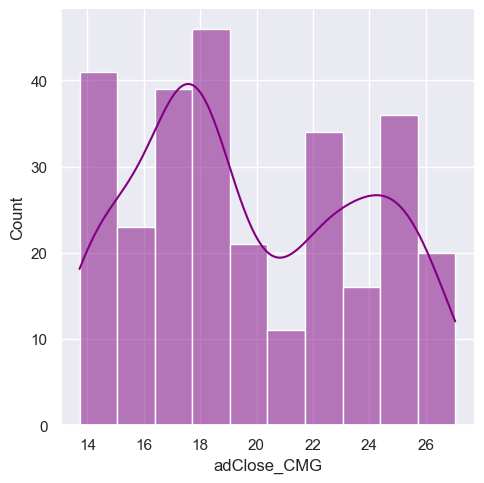

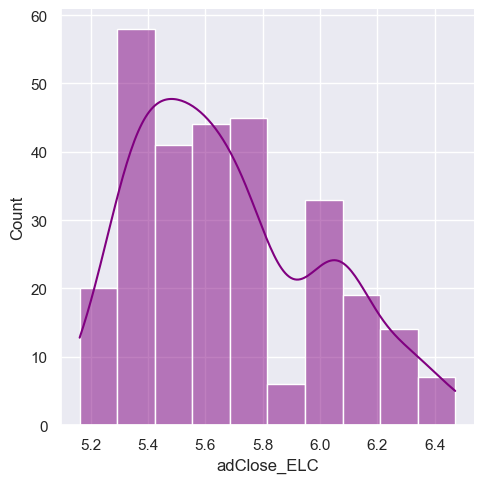

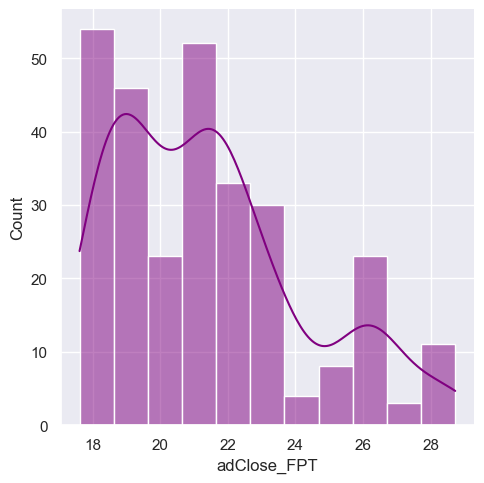

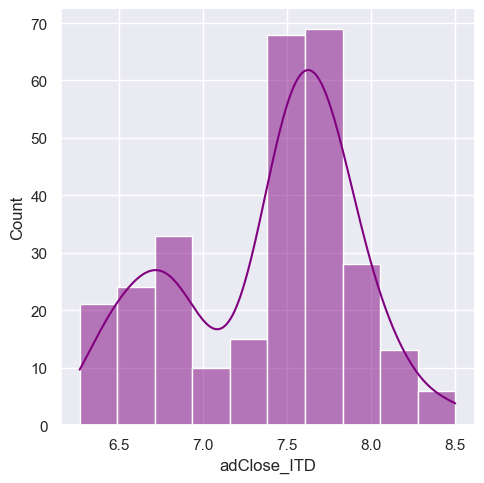

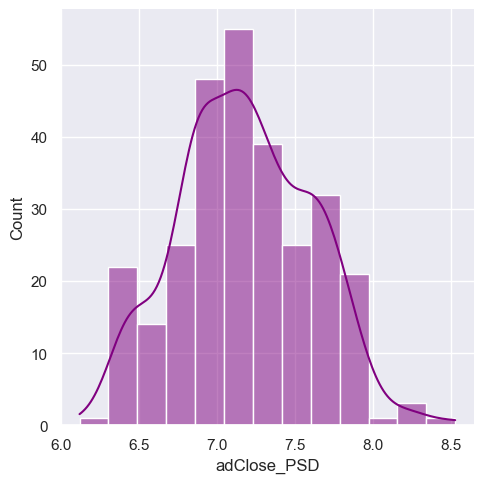

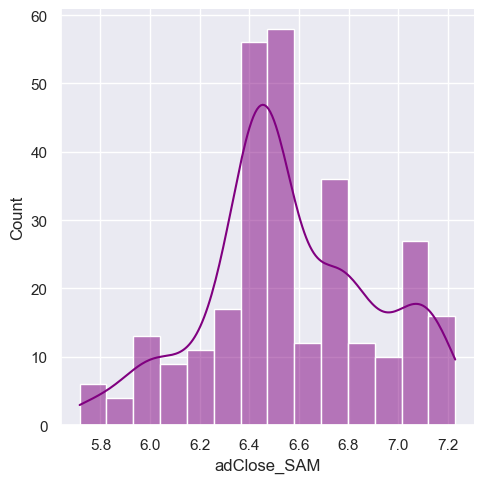

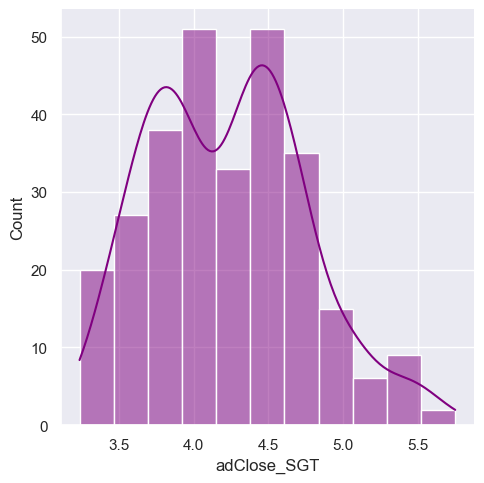

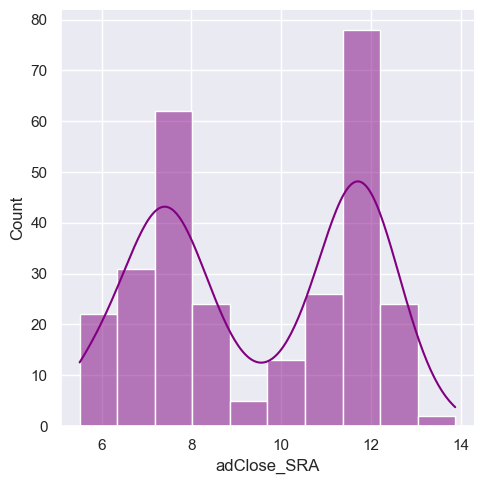

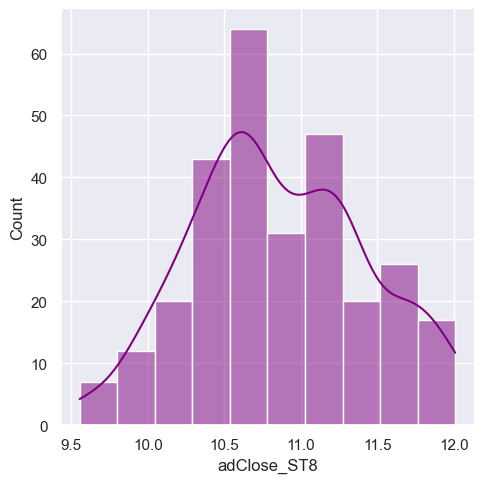

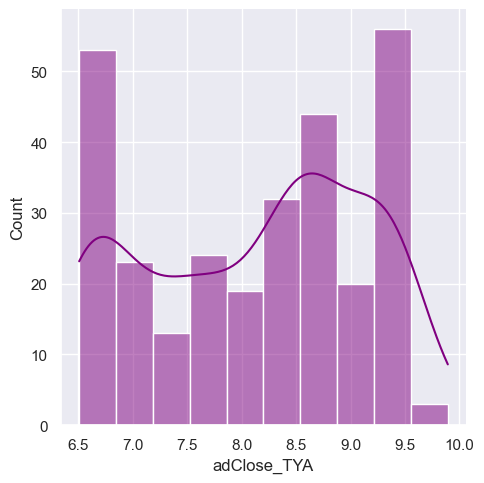

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_CMG,1
1,adClose_ELC,1
2,adClose_FPT,1
3,adClose_ITD,1
4,adClose_PSD,0
5,adClose_SAM,1
6,adClose_SGT,1
7,adClose_SRA,1
8,adClose_ST8,1
9,adClose_TYA,1


## **Engle - Grange Method**

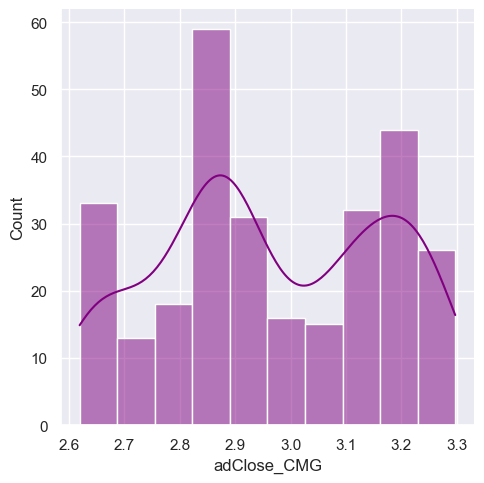

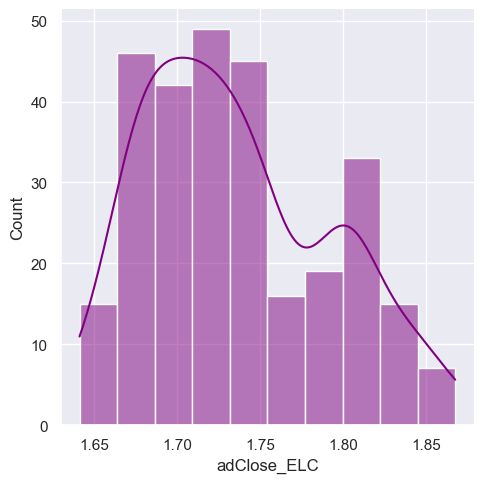

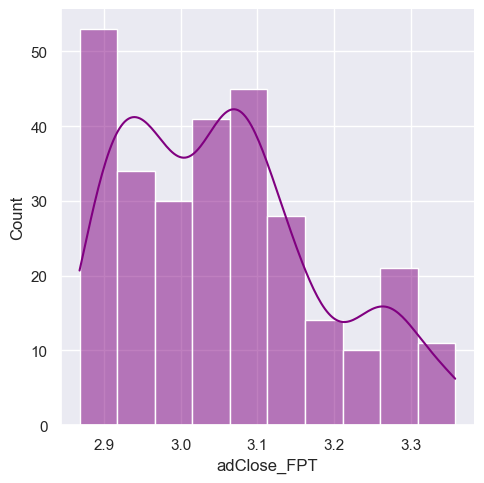

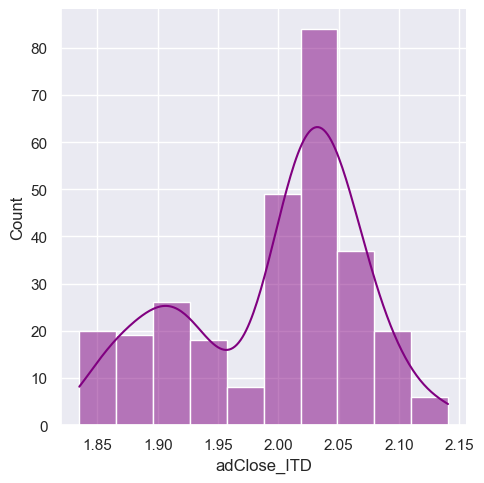

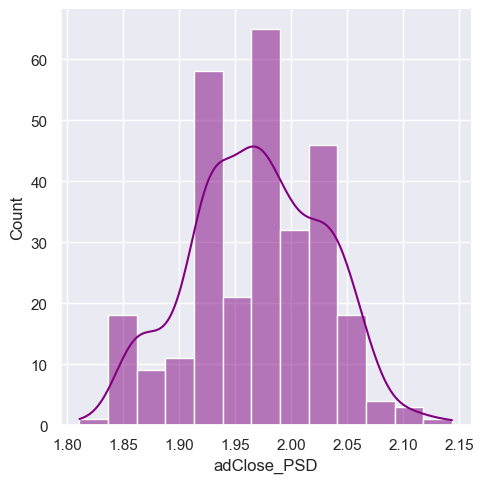

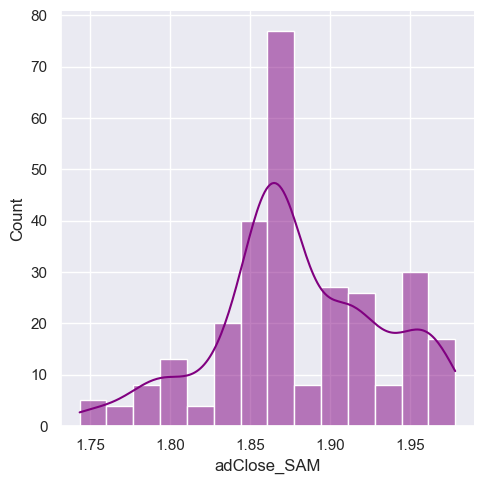

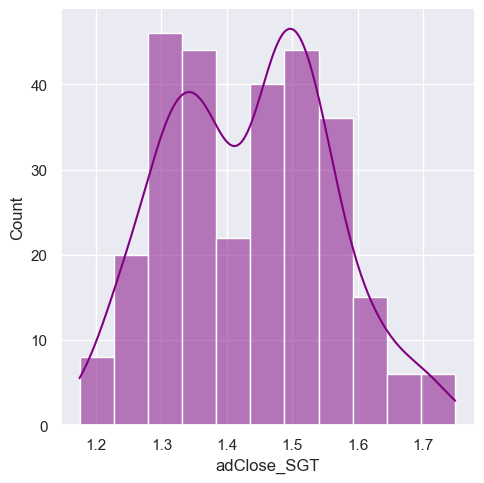

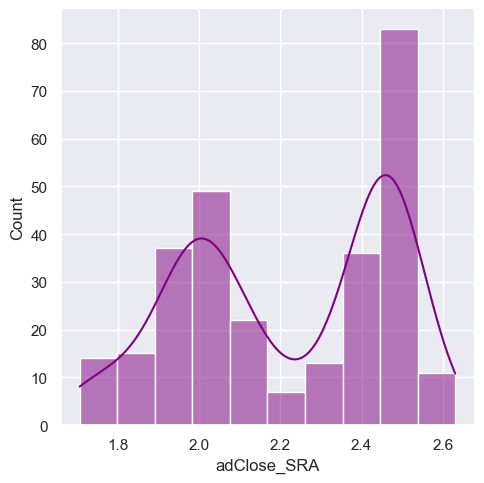

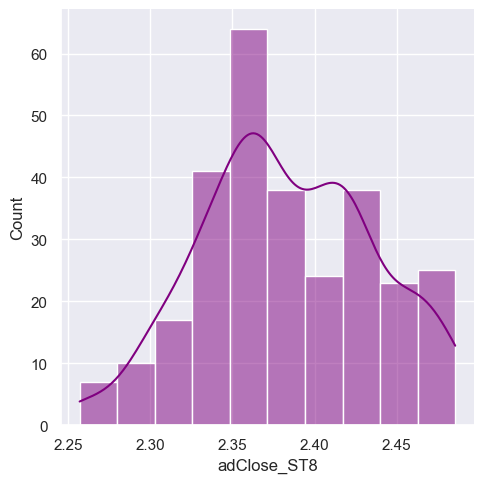

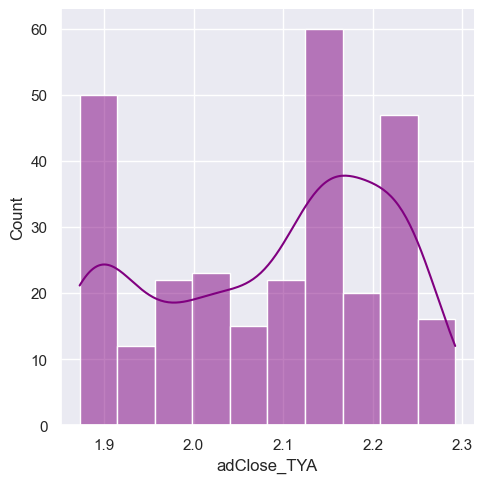

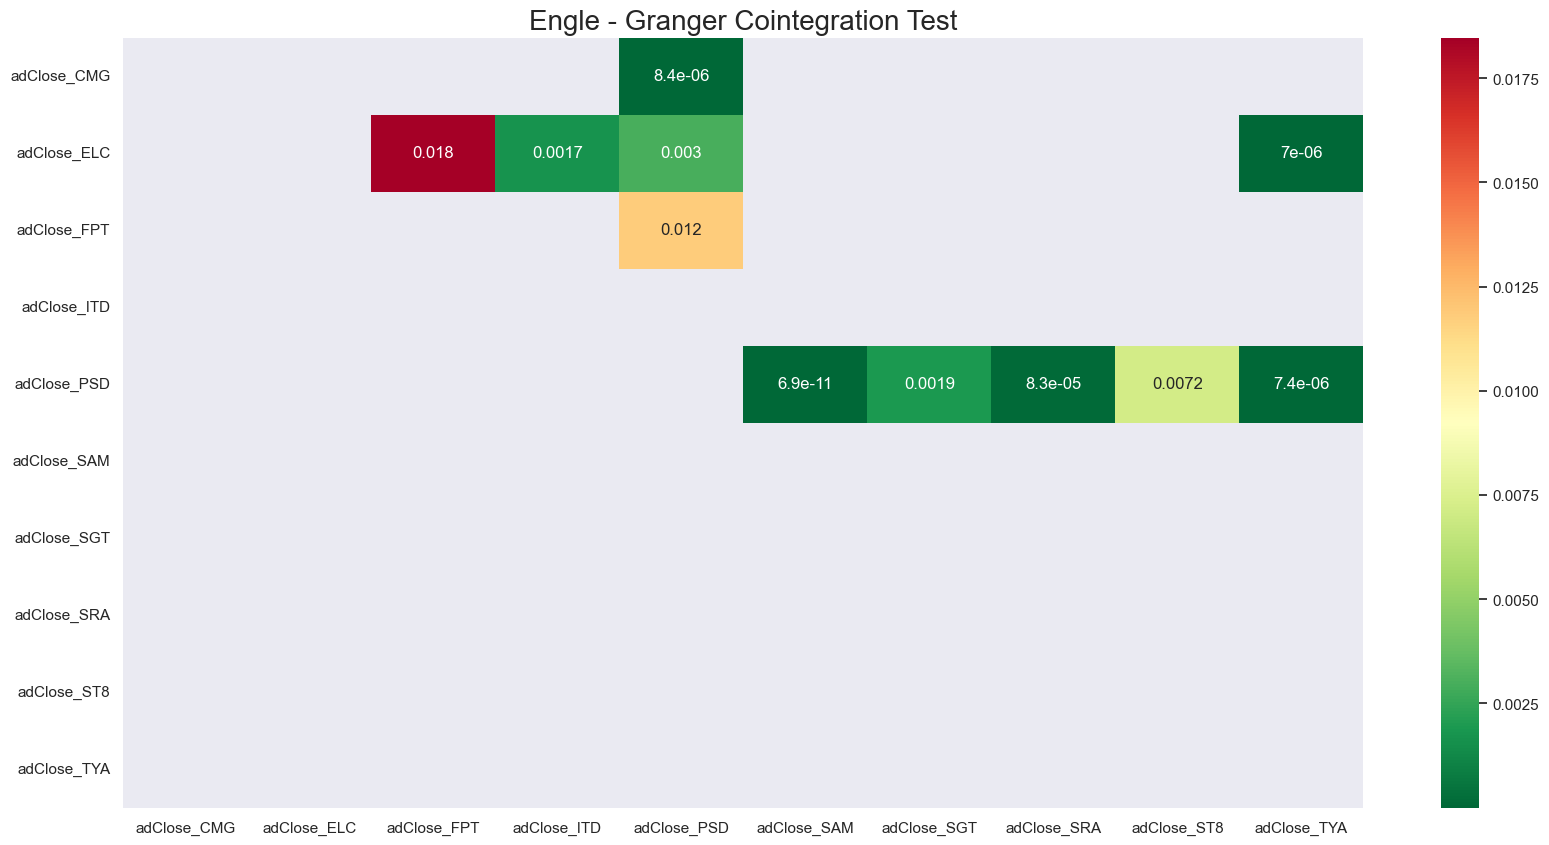

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [21]:
eg_pairs 

[['adClose_CMG', 'adClose_PSD'],
 ['adClose_ELC', 'adClose_FPT'],
 ['adClose_ELC', 'adClose_ITD'],
 ['adClose_ELC', 'adClose_PSD'],
 ['adClose_ELC', 'adClose_TYA'],
 ['adClose_FPT', 'adClose_PSD'],
 ['adClose_PSD', 'adClose_SAM'],
 ['adClose_PSD', 'adClose_SGT'],
 ['adClose_PSD', 'adClose_SRA'],
 ['adClose_PSD', 'adClose_ST8'],
 ['adClose_PSD', 'adClose_TYA']]

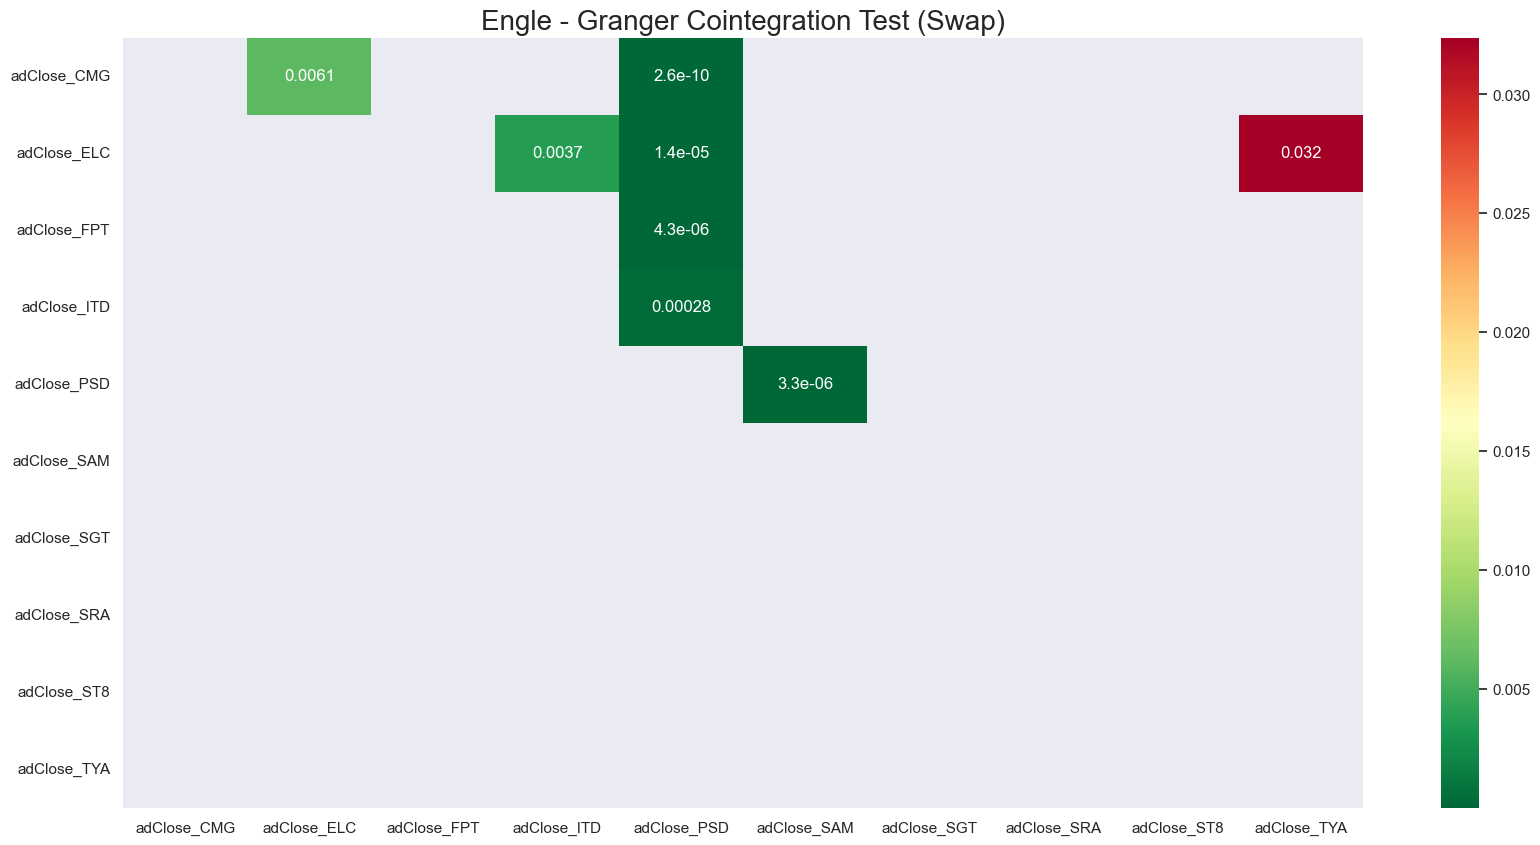

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [23]:
eg_pairs_swap

[['adClose_CMG', 'adClose_ELC'],
 ['adClose_CMG', 'adClose_PSD'],
 ['adClose_ELC', 'adClose_ITD'],
 ['adClose_ELC', 'adClose_PSD'],
 ['adClose_ELC', 'adClose_TYA'],
 ['adClose_FPT', 'adClose_PSD'],
 ['adClose_ITD', 'adClose_PSD'],
 ['adClose_PSD', 'adClose_SAM']]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [25]:
johansen_pairs

[['adClose_CMG', 'adClose_PSD'],
 ['adClose_CMG', 'adClose_SAM'],
 ['adClose_ELC', 'adClose_FPT'],
 ['adClose_ELC', 'adClose_ITD'],
 ['adClose_ELC', 'adClose_PSD'],
 ['adClose_ELC', 'adClose_ST8'],
 ['adClose_ELC', 'adClose_TYA'],
 ['adClose_FPT', 'adClose_PSD'],
 ['adClose_ITD', 'adClose_PSD'],
 ['adClose_ITD', 'adClose_ST8'],
 ['adClose_PSD', 'adClose_SAM'],
 ['adClose_PSD', 'adClose_SGT'],
 ['adClose_PSD', 'adClose_SRA'],
 ['adClose_PSD', 'adClose_ST8'],
 ['adClose_PSD', 'adClose_TYA'],
 ['adClose_SAM', 'adClose_ST8'],
 ['adClose_SGT', 'adClose_ST8']]

# **Result Summary**

In [26]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [28]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_CMG,adClose_ELC,,,x,,1
1,adClose_CMG,adClose_PSD,,x,x,x,3
2,adClose_CMG,adClose_SAM,,,,x,1
3,adClose_ELC,adClose_FPT,,x,,x,2
4,adClose_ELC,adClose_ITD,,x,x,x,3
5,adClose_ELC,adClose_PSD,x,x,x,x,4
6,adClose_ELC,adClose_ST8,,,,x,1
7,adClose_ELC,adClose_TYA,,x,x,x,3
8,adClose_FPT,adClose_ITD,x,,,,1
9,adClose_FPT,adClose_PSD,,x,x,x,3


In [29]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//tech//tech_pairs_formation_first_period_{hdt.today_date_to_digits()}.csv"
    )